<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404_05_29_input_emedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [48]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [49]:
!ls "/content/drive/My Drive/ASCE"


shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [50]:
import scipy.io

folder_path = '/content/drive/MyDrive/ASCE/shm01a.mat'
data = scipy.io.loadmat(folder_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dasy', 'dasy_dscr', 'filedescription', 'fsdasy'])


In [51]:
print('header:', data['__header__'])
print('version:',data['__version__'])
print('File description: ', data['filedescription'])
print('description:',data['dasy_dscr'])
# print(data['dasy'])
raw_descriptions = data['dasy_dscr'][0][0]
extracted_strings = [item[0] for item in raw_descriptions]
df_description = pd.DataFrame(extracted_strings, columns=['Description'])
print(df_description)


header: b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sun Sep 29 12:53:06 2002'
version: 1.0
File description:  ['Type:a (Ambient Vibration/Filtered Data) --  Config01: Fully Braced Config     ']
description: [[(array(['Base West side - EPI sensor X direction (N+)'], dtype='<U44'), array(['Base Center - EPI sensor Y direction (W+)'], dtype='<U41'), array(['Base East side - EPI sensor X direction (N+)'], dtype='<U44'), array(['1st Floor - N/S EPI Sensor at West end (N+)'], dtype='<U43'), array(['1st Floor - E/W FBA Sensor at Center (W+)'], dtype='<U41'), array(['1st Floor - N/S FBA Sensor at East end (N+)'], dtype='<U43'), array(['2nd Floor - N/S FBA Sensor at West end (N+)'], dtype='<U43'), array(['2nd Floor - E/W EPI Sensor at Center (W+)'], dtype='<U41'), array(['2nd Floor - N/S EPI Sensor at East end (N+)'], dtype='<U43'), array(['3rd Floor - N/S EPI Sensor at West end (N+)'], dtype='<U43'), array(['3rd Floor - E/W EPI Sensor at Center (W+)'], dtype='<U41'), array(['3rd Floor 

In [52]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        fields = raw._fieldnames
        channels = []
        for f in fields:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)     # → (n_samples, n_channels)

    return data, mat


base_dir = '/content/drive/MyDrive/ASCE/'

# state_files is a dictionary:{ label_1: "file1.mat", label_2: "file2.mat", ... }
# label is an integer or class ID (e.g., 0, 1, 2). fname is the name of a .mat file.
state_files = {
    1: 'shm01a.mat',   # state 1 → label 0
    2: 'shm02a.mat',   # state 2 → label 1
    3: 'shm03a.mat',   # state 3 → label 2
    4: 'shm04a.mat',   # state 4 → label 3
    5: 'shm05a.mat',   # state 5 → label 4
    6: 'shm06a.mat',   # state 6 → label 5
    7: 'shm07a.mat',   # state 7 → label 6
    8: 'shm08a.mat',   # state 8 → label 7
    9: 'shm09a.mat',   # state 9 → label 8
}

In [53]:
all_data, all_labels = [], []
for label, fname in state_files.items():
    path = os.path.join(base_dir, fname)
    dasy, mat = load_mat(path)
    print(f"{fname}: data shape = {dasy.shape}")
    all_data.append(dasy)
    all_labels.append(np.full(dasy.shape[0], label, dtype=np.int64))
print('Len Data == ',len(all_data))
all_data_concatenated = np.concatenate(all_data, axis=0)
all_label_concatenated = np.concatenate(all_labels)

print('all_data_concatenated: ', all_data_concatenated.shape)
print('all_label_concatenated: ', all_label_concatenated.shape)

# for i, arr in enumerate(all_data):
#     print(f"  Array {i+1}: {arr.shape}")



shm01a.mat: data shape = (60000, 16)
shm02a.mat: data shape = (60000, 16)
shm03a.mat: data shape = (60000, 16)
shm04a.mat: data shape = (60000, 16)
shm05a.mat: data shape = (60000, 16)
shm06a.mat: data shape = (45568, 16)
shm07a.mat: data shape = (180000, 16)
shm08a.mat: data shape = (180000, 16)
shm09a.mat: data shape = (180000, 16)
Len Data ==  9
all_data_concatenated:  (885568, 16)
all_label_concatenated:  (885568,)


In [54]:
data_state1 = all_data[0]
data_state2 = all_data[1]
# # data_state3 = all_data[2]
# # data_state4 = all_data[3]
# # data_state5 = all_data[4]
# # data_state6 = all_data[5]
# # data_state7 = all_data[6]
# # data_state8 = all_data[7]
# # data_state9 = all_data[8]
# # print(data_state1.dtype)
# # print(data_state1.shape)
# # print(data_state2.shape)
columns_to_delete = [0, 1, 2, -1]
data_state1 = np.delete(data_state1 ,columns_to_delete, axis=1)
data_state2 = np.delete(data_state2 ,columns_to_delete, axis=1)
print(data_state1.shape)
print(data_state2.shape)


(60000, 12)
(60000, 12)


In [55]:
# ---------- LEAK-SAFE DATASET BUILD (no random_split) ----------
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Windowing that also returns window start indices
def build_windows(x, L=1024, S=512):
    n, c = x.shape
    starts = np.arange(0, n - L + 1, S)
    wins = np.stack([x[s:s+L, :] for s in starts], axis=0)   # (n_win, L, C)
    return wins, starts

# 2) Split the raw time axis into contiguous blocks (half-open ranges)
def split_ranges(n_total, train_frac=0.6, val_frac=0.2):
    t1 = int(n_total * train_frac)
    t2 = int(n_total * (train_frac + val_frac))
    return (0, t1), (t1, t2), (t2, n_total)  # (lo, hi)

# 3) Keep windows that are fully inside each block, with an EMBARGO gap
def mask_windows_into_block(starts, L, block, embargo):
    lo = block[0] + embargo
    hi = block[1] - embargo
    return (starts >= lo) & (starts + L <= hi)

# 4) Optional sanity: check minimum separation between two sets of starts
def min_separation(starts_a, starts_b):
    if len(starts_a) == 0 or len(starts_b) == 0:
        return np.inf
    a = np.sort(np.asarray(starts_a)); b = np.sort(np.asarray(starts_b))
    i = j = 0; best = np.inf
    while i < len(a) and j < len(b):
        best = min(best, abs(a[i]-b[j]))
        if a[i] < b[j]: i += 1
        else: j += 1
    return best

# --------- choose your windowing/split params ----------
L, S = 1024, 512       # overlapped windows are fine now because we enforce an embargo
EMBARGO = 1024         # >= L is recommended; use >L if you have long filters/rolling ops

# Build windows + starts per state
seg1, st1 = build_windows(data_state1, L, S)
seg2, st2 = build_windows(data_state2, L, S)

# Split raw time for each state
tr1, va1, te1 = split_ranges(data_state1.shape[0], 0.6, 0.2)
tr2, va2, te2 = split_ranges(data_state2.shape[0], 0.6, 0.2)

# Keep only windows fully inside each block, far from edges by EMBARGO
m_tr1 = mask_windows_into_block(st1, L, tr1, EMBARGO)
m_va1 = mask_windows_into_block(st1, L, va1, EMBARGO)
m_te1 = mask_windows_into_block(st1, L, te1, EMBARGO)

m_tr2 = mask_windows_into_block(st2, L, tr2, EMBARGO)
m_va2 = mask_windows_into_block(st2, L, va2, EMBARGO)
m_te2 = mask_windows_into_block(st2, L, te2, EMBARGO)

# Assemble balanced datasets (class 0 = state1, class 1 = state2)
X_train = np.vstack([seg1[m_tr1], seg2[m_tr2]])
y_train = np.concatenate([np.zeros(m_tr1.sum(), np.int64), np.ones(m_tr2.sum(), np.int64)])

X_val   = np.vstack([seg1[m_va1], seg2[m_va2]])
y_val   = np.concatenate([np.zeros(m_va1.sum(), np.int64), np.ones(m_va2.sum(), np.int64)])

X_test  = np.vstack([seg1[m_te1], seg2[m_te2]])
y_test  = np.concatenate([np.zeros(m_te1.sum(), np.int64), np.ones(m_te2.sum(), np.int64)])

print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)
print("Class counts (train/val/test):",
      np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

# Sanity: verify no near-duplicates across splits for each state
print("Min sep (state1) train–val:",  min_separation(st1[m_tr1], st1[m_va1]))
print("Min sep (state1) train–test:", min_separation(st1[m_tr1], st1[m_te1]))
print("Min sep (state2) train–val:",  min_separation(st2[m_tr2], st2[m_va2]))
print("Min sep (state2) train–test:", min_separation(st2[m_tr2], st2[m_te2]))

# Convert to PyTorch datasets/loaders (NO random_split)
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds   = TensorDataset(torch.from_numpy(X_val).float(),   torch.from_numpy(y_val).long())
test_ds  = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test).long())

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
# ---------------------------------------------------------------


Train/Val/Test sizes: (130, 1024, 12) (34, 1024, 12) (36, 1024, 12)
Class counts (train/val/test): [65 65] [17 17] [18 18]
Min sep (state1) train–val: 3584
Min sep (state1) train–test: 15360
Min sep (state2) train–val: 3584
Min sep (state2) train–test: 15360


In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# data_state1 = scaler.fit_transform(data_state1)
# data_state2 = scaler.fit_transform(data_state2)

# print('data_state1', data_state1.shape)
# print('data_state_normalized', normalized_matrix.shape)

# # برای بررسی، حداقل و حداکثر مقادیر ستون اول ماتریس نرمال‌شده را چاپ کنید
# print("min", data_state1[:, 0].min())
# print("max", data_state1[:, 0].max())

# print("normalizedd_min", normalized_matrix[:, 0].min())
# print("normalized_max", normalized_matrix[:, 0].max())

# print(data_state1[:,0])

In [38]:
# def segment_signal(x, L=1024, S=1024):
#     n_samples, n_channels = x.shape
#     n_windows = int(np.floor((n_samples - L) / S) + 1)
#     windows = []

#     for start in range(0, n_samples - L + 1, S):
#         windows.append(x[start:start+L, 0::])
#     return np.stack(windows, axis=0)

# seg1 = segment_signal(data_state1, L=1024, S=512) # return(n_windows, L, n_channels)
# seg2 = segment_signal(data_state2, L=1024, S=512)
# # seg3 = segment_signal(data_state3, L=1024, S=512)
# # seg4 = segment_signal(data_state4, L=1024, S=512)
# # seg5 = segment_signal(data_state5, L=1024, S=512)
# # seg6 = segment_signal(data_state6, L=1024, S=512)
# # seg7 = segment_signal(data_state7, L=1024, S=512)
# # seg8 = segment_signal(data_state8, L=1024, S=512)
# # seg9 = segment_signal(data_state9, L=1024, S=512)

# print("State1 windows:", seg1.shape)
# print("State2 windows:", seg2.shape)
# # print("State3 windows:", seg3.shape)
# # print("State4 windows:", seg4.shape)
# # print("State5 windows:", seg5.shape)
# # print("State6 windows:", seg6.shape)
# # print("State7 windows:", seg7.shape)
# # print("State8 windows:", seg8.shape)
# # print("State9 windows:", seg9.shape)

State1 windows: (116, 1024, 12)
State2 windows: (116, 1024, 12)


In [39]:
# X = np.vstack([seg1, seg2])
# y = np.concatenate([
#     np.zeros(len(seg1), dtype=np.int64),   # label 0 for state1
#     np.ones(len(seg2),  dtype=np.int64),   # label 1 for state3
# ])

# # X = np.vstack([seg1, seg2, seg3, seg4, seg5, seg6, seg7, seg8, seg9])
# # y = np.concatenate([
# #     np.zeros(len(seg1), dtype=np.int64),     # label 0 for state1
# #     1*np.ones(len(seg2),  dtype=np.int64),   # label 1 for state2
# #     2*np.ones(len(seg3),  dtype=np.int64),   # label 2 for state3
# #     3*np.ones(len(seg4),  dtype=np.int64),   # label 3 for state4
# #     4*np.ones(len(seg5),  dtype=np.int64),   # label 4 for state5
# #     5*np.ones(len(seg6),  dtype=np.int64),   # label 5 for state6
# #     6*np.ones(len(seg7),  dtype=np.int64),   # label 6 for state7
# #     7*np.ones(len(seg8),  dtype=np.int64),   # label 7 for state8
# #     8*np.ones(len(seg9),  dtype=np.int64),   # label 8 for state9

# # ])
# print("X shape:", X.shape)
# print("y shape:", y.shape, "unique labels:", np.unique(y))


X shape: (232, 1024, 12)
y shape: (232,) unique labels: [0 1]


In [40]:
# from torch.utils.data import random_split
# from torch.utils.data import TensorDataset

# # # 1) Wrap in a Dataset
# # class ASCEWindowDataset(torch.utils.data.Dataset):
# #     def __init__(self, X, y):
# #         # ensure tensors
# #         if not isinstance(X, torch.Tensor):
# #             X = torch.from_numpy(X).float()
# #         if not isinstance(y, torch.Tensor):
# #             y = torch.from_numpy(y).long()
# #         self.X = X   # shape (N, L, C)
# #         self.y = y   # shape (N,)
# #     def __len__(self):
# #         return len(self.y)
# #     def __getitem__(self, idx):
# #         return self.X[idx], self.y[idx]

# # dataset = ASCEWindowDataset(X, y)
# print("Minimum label:", np.min(y))
# print("Maximum label:", np.max(y))
# print("Number of unique labels:", len(np.unique(y)))

# dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())


# # 2) Split sizes
# N = len(dataset)
# n_train = int(0.8 * N)
# n_val   = int(0.1 * N)
# n_test  = N - n_train - n_val

# train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
#                                    generator=torch.Generator().manual_seed(42))

# # 3) DataLoaders
# batch_size = 32

# train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
# val_loader   = DataLoader(val_ds,   batch_size = batch_size, shuffle = False)
# test_loader  = DataLoader(test_ds,  batch_size = batch_size, shuffle = False)

# # Sanity check
# xb, yb = next(iter(train_loader))
# print("train batch X:", xb.shape)  # (32, 1024, 15)
# print("train batch y:", yb.shape)  # (32,)


Minimum label: 0
Maximum label: 1
Number of unique labels: 2
train batch X: torch.Size([32, 1024, 12])
train batch y: torch.Size([32])


In [56]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvEmbedding(nn.Module):
    """
    Map (B, S, C) → (B, S_out, D) using temporal 1D convolutions.
    - Convs run along time; channels are features.
    - Stride can downsample the sequence to speed up the Transformer.
    """
    def __init__(self, n_channels, d_model, hidden=128, kernel_size=7, stride=1, dropout=0.1):
        super().__init__()
        pad = (kernel_size - 1) // 2  # 'same' for odd kernels

        # A small CNN stack: pointwise -> depthwise -> pointwise
        self.pw1 = nn.Conv1d(n_channels, hidden, kernel_size=1, bias=False)
        self.dw  = nn.Conv1d(hidden, hidden, kernel_size=kernel_size, stride=stride,
                             padding=pad, groups=hidden, bias=False)  # depthwise temporal conv
        self.pw2 = nn.Conv1d(hidden, d_model, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.bn3 = nn.BatchNorm1d(d_model)

        self.act = nn.GELU()
        self.do  = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, S, C) → Conv1d expects (B, C, S)
        x = x.transpose(1, 2)                 # (B, C, S)
        x = self.pw1(x)                       # (B, H, S)
        x = self.bn1(x); x = self.act(x)

        x = self.dw(x)                        # (B, H, S_out)
        x = self.bn2(x); x = self.act(x); x = self.do(x)

        x = self.pw2(x)                       # (B, D, S_out)
        x = self.bn3(x); x = self.act(x)
        x = x.transpose(1, 2)                 # (B, S_out, D)
        return x


class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 n_channels=12,
                 d_model=128,
                 n_heads=4,
                 num_layers=3,
                 d_ff=256,
                 dropout=0.1,
                 seq_len=1024,
                 num_classes=2,
                 # CNN embedding hyperparams:
                 cnn_hidden=128,
                 cnn_kernel=7,
                 cnn_stride=1):
        super().__init__()

        # 1) CNN-based input embedding along time
        self.cnn_embed = ConvEmbedding(
            n_channels=n_channels,
            d_model=d_model,
            hidden=cnn_hidden,
            kernel_size=cnn_kernel,
            stride=cnn_stride,
            dropout=dropout
        )

        # Effective max length after CNN (if stride > 1 we downsample)
        self.max_len = math.ceil(seq_len / cnn_stride)

        # 2) Learned positional embeddings for the (possibly reduced) sequence
        self.pos_emb = nn.Parameter(torch.zeros(1, self.max_len, d_model))

        # 3) Transformer encoder
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # 4) Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # Optional: better init for pos_emb
        nn.init.trunc_normal_(self.pos_emb, std=0.02)

    def forward(self, x):
        # x: (B, S, C)

        # a) CNN embedding (may downsample S → S_out if stride > 1)
        x = self.cnn_embed(x)                       # (B, S_out, D)

        # b) add positional encoding
        S = x.size(1)
        x = x + self.pos_emb[:, :S, :]              # (B, S_out, D)

        # c) Transformer encoding
        x = self.transformer(x)                     # (B, S_out, D)

        # d) temporal pooling
        x = x.mean(dim=1)                           # (B, D)

        # e) classify
        return self.classifier(x)                   # (B, num_classes)


In [27]:
# import torch
# import torch.nn as nn

# class TimeSeriesTransformer(nn.Module):
#     def __init__(self,
#                  n_channels=12,
#                  d_model=128, # Dimension of the model's internal representation (hidden size)
#                  n_heads=4,
#                  num_layers=3, # Number of Transformer encoder layers
#                  d_ff=256, # Dimension of the feed-forward network in each encoder layer
#                  dropout=0.1,
#                  seq_len=1024,
#                  num_classes=2):
#         super().__init__()
#         # 1) Project 15→d_model per time‐step
#         self.input_proj = nn.Linear(in_features = n_channels, out_features = d_model)
#         # This nn.Linear layer transforms each time step's features from n_channels to d_model.
#         # It's like converting your sensor readings into a higher-dimensional, richer representation

#         # 2) Learned positional embeddings
#         self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, d_model))
#         #  This means the model will learn the best way to
#         #  represent the position of each time step in the sequence.

#         # 3) Transformer encoder layers (batch_first=True so input is (B, S, D))
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=n_heads,
#             dim_feedforward=d_ff,
#             dropout=dropout,
#             batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # 4) Classification head: from d_model → d_model//2 → num_classes
#         #    *Notice the first Linear’s in_features = d_model*
#         #    *and the final Linear’s in_features = d_model//2*
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(d_model),
#             nn.Linear(d_model, d_model//2),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_model//2, num_classes)
#         )

#     def forward(self, x):
#         # x: (batch, seq_len, n_channels)

#         # a) embed
#         x = self.input_proj(x)                        # → (batch, seq_len, d_model)

#         # b) add positional encoding
#         x = x + self.pos_emb[:, :x.size(1), :]        # → (batch, seq_len, d_model)

#         # c) encode
#         x = self.transformer(x)                       # → (batch, seq_len, d_model)

#         # d) **pool over the time axis** so we drop seq_len (1024)
#         x = x.mean(dim=1)                             # → (batch, d_model)

#         # e) classify
#         return self.classifier(x)                     # → (batch, num_classes)


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model  = TimeSeriesTransformer(
    n_channels=12,
    d_model=128,
    n_heads=4,
    num_layers=3,
    d_ff=256,
    dropout=0.3,
    seq_len=1024,
    num_classes=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)



Using device: cpu


In [62]:
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [63]:
from sklearn.metrics import accuracy_score

def train_epoch(loader):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds.extend(logits.argmax(dim=1).cpu().tolist())
        targets.extend(yb.cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

def eval_epoch(loader):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            running_loss += loss.item() * xb.size(0)
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(yb.cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc


In [ ]:
num_epochs = 5
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc     = eval_epoch(val_loader)
    # scheduler.step()

    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    val_losses  .append(val_loss)
    val_accs    .append(val_acc)

    print(f"Epoch {epoch:02d} │ "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} ││ "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.3f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_asce_transformer.pt")
        print("  ↳ new best, model saved.")


In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def eval_epoch(loader):
    model.eval()
    running_loss = 0.0
    preds, targets, probs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            running_loss += loss.item() * xb.size(0)
            pr = logits.softmax(dim=1)[:,1]  # prob of class 1
            probs.extend(pr.cpu().numpy().tolist())
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(yb.cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    try:
        auc = roc_auc_score(targets, probs)
    except ValueError:
        auc = float('nan')
    f1 = f1_score(targets, preds)
    return avg_loss, acc, f1, auc
_, acc, f1, auc = eval_epoch(test_loader)
print(f"Test: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}")

Test: acc=1.000, f1=1.000, auc=1.000


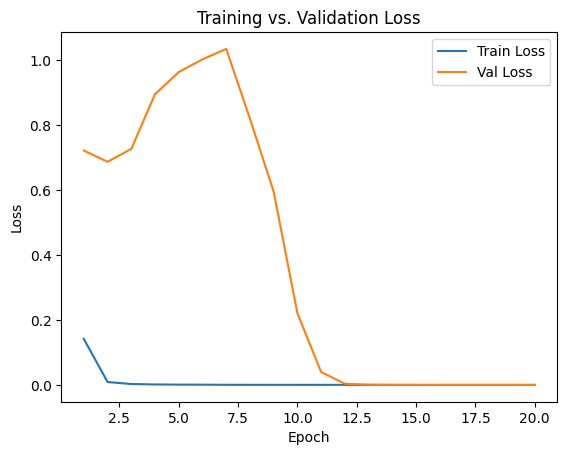

In [36]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


In [22]:
# ─── Cell E ───
# [Training loop here]
# At the end, you have a trained model in memory or you load the best checkpoint:
model.load_state_dict(torch.load("best_asce_transformer.pt"))
model.eval()
# ────────────────────────────────────────────────────────────

# ─── Cell F (new) ───
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# (1) Move model to CPU for visualization
model_cpu = model.to('cpu')

# (2) Create a DataLoader over the entire dataset (no shuffling)
full_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# (3) Extract the d_model‐dim feature for each window by forwarding through everything
all_features = []
all_labels   = []
with torch.no_grad():
    for xb, yb in full_loader:
        xb = xb.cpu()
        # Manually run up through the transformer, stopping at the pooled output:
        x_proj   = model_cpu.input_proj(xb)                             # (B, L, d_model)
        x_pos    = x_proj + model_cpu.pos_emb[:, :x_proj.size(1), :]     # add pos emb
        x_trans  = model_cpu.transformer(x_pos)                          # (B, L, d_model)
        features = x_trans.mean(dim=1)                                   # (B, d_model)
        all_features.append(features.numpy())
        all_labels.append(yb.numpy())

# (4) Stack everything into arrays
features_array = np.vstack(all_features)   # shape: (n_windows, d_model)
labels_array   = np.concatenate(all_labels)

# (5) PCA → 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_array)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_result[:,0], pca_result[:,1],
    c=labels_array, cmap='coolwarm', alpha=0.7
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Transformer Features')
plt.legend(*scatter.legend_elements(), title="State")
plt.show()

# (6) t-SNE → 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=42)
tsne_result = tsne.fit_transform(features_array)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    tsne_result[:,0], tsne_result[:,1],
    c=labels_array, cmap='coolwarm', alpha=0.7
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Transformer Features')
plt.legend(*scatter.legend_elements(), title="State")
plt.show()
# ────────────────────────────────────────────────────────────


AttributeError: 'TimeSeriesTransformer' object has no attribute 'input_proj'

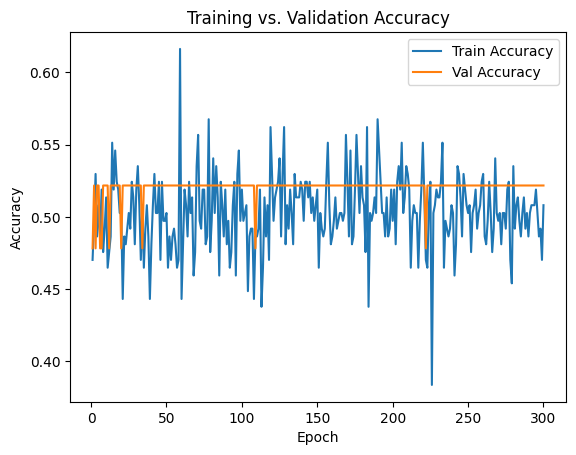

In [ ]:
plt.figure()
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()


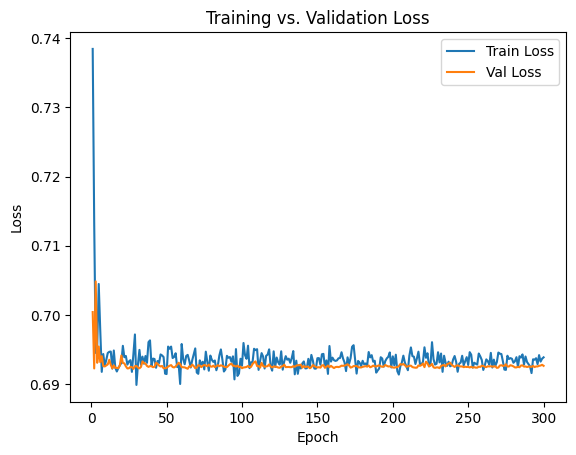

Confusion Matrix:
              Pred State1  Pred State2
True State1            0           14
True State2            0           10


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch

# 1) Plot training & validation loss
epochs = list(range(1, len(train_losses) + 1))
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# 2) Compute confusion matrix on the test set
model.eval()
# Move model to CPU before inference to match data device
model_cpu = model.to('cpu')
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        # Move data to CPU to match model device
        xb, yb = xb.to('cpu'), yb.to('cpu')
        logits = model_cpu(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.cpu().numpy())

# Build & display as a DataFrame
cm = confusion_matrix(all_targets, all_preds)
df_cm = pd.DataFrame(cm,
    index=['True State1','True State2'],
    columns=['Pred State1','Pred State2']
    # index=['True State1','True State2','True State3','True State4','True State5', 'True State6', 'True State7', 'True State8','True State9'],
    # columns=['Pred State1','Pred State2','Pred State3','Pred State4', 'Pred State5', 'Pred State6', 'Pred State7', 'Pred State8', 'Pred State9']
)
print("Confusion Matrix:\n", df_cm)